# Urban Sound Classifier using CNN v2

第一个CNN的分类器效果惨烈，有许多细节都没有注意到，感觉修改也令人心烦，从头开始。老实说我也不知道这次能不能成功，边做边看吧。

## 上次踩过的坑和经验

1. 之前把频谱当作训练数据输入，但频谱里的数值都是负数，后来换为了绝对值。但这样其实也不行，应该要进行normalization。把是把值的范围限制在[-1,1]还是[0,1]还不清楚。我的想法是根据relu的性质，应当是[0,1]。（结果：应当时-1到1，值是*w+b再激活，所以负数不影响）
2. 计算mfcc时的维度一般是40，有用的一般是2到13维。

## 构想

首先明确一下这次要做的事情：

- 训练集：[UrbanSound8K dataset](https://serv.cusp.nyu.edu/projects/urbansounddataset/urbansound8k.html)，训练用fold 1-3，validation用从整个数据集里面随意找一些样本，test用fold 10。
- 输入：MFCC，normalization为mean=0, var=1。
- 网络：一个非常简单的CNN，两层conv2D层，进入一个全连接层。
- 输出：10个class

## 动手，去做

In [1]:
# draw
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# basic handling
import os
import glob
import pickle
import numpy as np
# audio
import librosa
import librosa.display
import IPython.display
# normalization
import sklearn
# nn
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler
keras.__version__

Using TensorFlow backend.


'2.2.0'

指定dataset的位置

In [2]:
parent_dir = '../data/UrbanSound8K/audio/'

train_dir = 'train/'
val_dir = 'val/'
test_dir = 'fold10/'

file_name = '*.wav'

train_files = glob.glob(os.path.join(parent_dir, train_dir, file_name))
val_files = glob.glob(os.path.join(parent_dir, val_dir, file_name))
test_files = glob.glob(os.path.join(parent_dir, test_dir, file_name))

定义一个函数用于读取音频片段，库里的片段几乎都是4s，但有一部分小于4秒，将它们补零。采样率22050，4秒一共88200个采样点。

In [3]:
def load_clip(filename):
    x, sr = librosa.load(filename)
    x = np.pad(x,(0,88200-x.shape[0]),'constant')
    return x, sr

再定义一个函数，用于提取片段的mfcc并进行normalization。

In [4]:
def extract_feature(filename):
    x, sr = load_clip(filename)
    mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=40)
    norm_mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
    return norm_mfccs

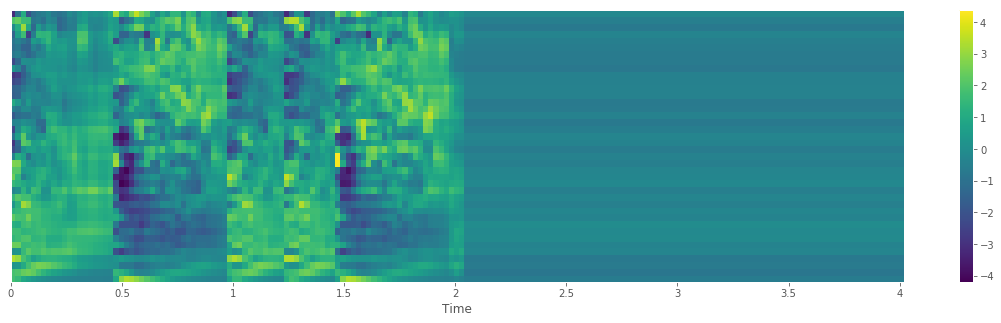

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-1.25692648e-14  1.57869864e-16  5.60887239e-16  4.24836787e-16
  1.40542683e-16  6.23778486e-16  4.52431926e-17  4.46014452e-17
 -4.88530218e-17 -4.99921235e-16 -3.52640203e-16 -4.04300870e-17
 -6.48164887e-17 -5.00562982e-17 -1.41505305e-16  1.22573756e-16
  1.66854327e-17 -4.73609591e-16 -1.86748497e-16 -4.96712498e-16
 -7.89349318e-17 -2.19477615e-16 -3.76063984e-16 -8.41972606e-16
  0.00000000e+00 -2.95203810e-16 -3.54244572e-16  2.27820332e-16
  2.80443620e-16 -2.25253342e-16 -2.65041682e-16 -4.06867860e-16
 -1.21932008e-16  3.97883396e-17  5.10830941e-16  1.84823255e-16
  3.38842634e-16 -8.98446378e-18  3.70930005e-16 -1.42147052e-16]


In [5]:
# 测试extract_feature是否正常工作
mfccs = extract_feature('./1.wav')
plt.figure(figsize=(20,5))
librosa.display.specshow(mfccs, sr=22050, x_axis='time', cmap='viridis')
plt.colorbar()
plt.show()
print (mfccs.var(axis=1))
print (mfccs.mean(axis=1))

读取整个数据集，从整个数据集提取特征与标签

In [6]:
def load_dataset(filenames):
    features, labels = np.empty((0,40,173)), np.empty(0)
    cnt = 0;
    cnt_all = len(filenames)
    
    for filename in filenames:
        mfccs = extract_feature(filename)
        features = np.append(features,mfccs[None],axis=0)
        cnt+=1
        if(cnt%100==0):
            print([str(cnt)+' / '+str(cnt_all)+' finished'])
        labels = np.append(labels, filename.split('\\')[1].split('-')[1])
    return np.array(features), np.array(labels, dtype=np.int)

将训练过程可视化的函数

In [7]:
def show_history(history):
    print(history.history.keys())
    fig = plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower left')
    plt.show()

如果还没有将音频转换为features，则进行转化并保存。

In [8]:
# train_x, train_y = load_dataset(train_files)
# pickle.dump(train_x, open('./train_x.dat', 'wb'))
# pickle.dump(train_y, open('./train_y.dat', 'wb'))

# val_x, val_y = load_dataset(val_files)
# pickle.dump(val_x, open('./val_x.dat', 'wb'))
# pickle.dump(val_y, open('./val_y.dat', 'wb'))

# test_x, test_y = load_dataset(test_files)
# pickle.dump(test_x, open('./test_x.dat', 'wb'))
# pickle.dump(test_y, open('./test_y.dat', 'wb'))

如果已经有features了，就从文件中读取。

In [9]:
train_x = pickle.load(open('./train_x.dat', 'rb'))
train_y = pickle.load(open('./train_y.dat', 'rb'))
val_x = pickle.load(open('./val_x.dat', 'rb'))
val_y = pickle.load(open('./val_y.dat', 'rb'))
test_x = pickle.load(open('./test_x.dat', 'rb'))
test_y = pickle.load(open('./test_y.dat', 'rb'))

接下来对feature进行一些预处理。mfcc是二维数据，要输入conv2D层，要把它变为3维数据。因为是聚类，所以把label转化为categories

In [10]:
train_x = train_x.reshape(train_x.shape[0],train_x.shape[1],train_x.shape[2],1)
val_x = val_x.reshape(val_x.shape[0],val_x.shape[1],val_x.shape[2],1)
test_x = test_x.reshape(test_x.shape[0],test_x.shape[1],test_x.shape[2],1)

train_y = to_categorical(train_y)
val_y = to_categorical(val_y)
test_y = to_categorical(test_y)

Pre-processing至此结束，检查一下我们的训练集

In [12]:
print(train_x.shape)
print(train_y.shape)

(2686, 40, 173, 1)
(2686, 10)


没有问题的话就开始搭建模型

In [13]:
model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu',input_shape = train_x.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5)) 
model.add(Convolution2D(32, (3, 3),  activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary(line_length=80)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_1 (Conv2D)                   (None, 38, 171, 32)             320         
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 19, 85, 32)              0           
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 19, 85, 32)              0           
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 17, 83, 32)              9248        
________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)      (None, 8, 41, 32)               0           
________________________________________________________________________________
dropout_2 (Dropout)         

In [14]:
history = model.fit(train_x, train_y, epochs=10, batch_size=32, validation_data=(val_x, val_y))

Train on 2686 samples, validate on 83 samples
Epoch 1/10
2686/2686 [==============================] - 13s 5ms/step - loss: 2.0973 - acc: 0.2223 - val_loss: 1.8910 - val_acc: 0.3012
Epoch 2/10
2686/2686 [==============================] - 8s 3ms/step - loss: 1.5507 - acc: 0.4151 - val_loss: 1.6829 - val_acc: 0.3494
Epoch 3/10
2686/2686 [==============================] - 8s 3ms/step - loss: 1.2991 - acc: 0.5316 - val_loss: 1.4978 - val_acc: 0.4458
Epoch 4/10
2686/2686 [==============================] - 8s 3ms/step - loss: 1.1322 - acc: 0.5934 - val_loss: 1.7221 - val_acc: 0.3976
Epoch 5/10
2686/2686 [==============================] - 8s 3ms/step - loss: 1.0006 - acc: 0.6385 - val_loss: 1.7749 - val_acc: 0.4096
Epoch 6/10
2686/2686 [==============================] - 8s 3ms/step - loss: 0.9274 - acc: 0.6660 - val_loss: 1.4768 - val_acc: 0.4578
Epoch 7/10
2686/2686 [==============================] - 8s 3ms/step - loss: 0.7824 - acc: 0.7226 - val_loss: 1.4234 - val_acc: 0.4819
Epoch 8/10
2686

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


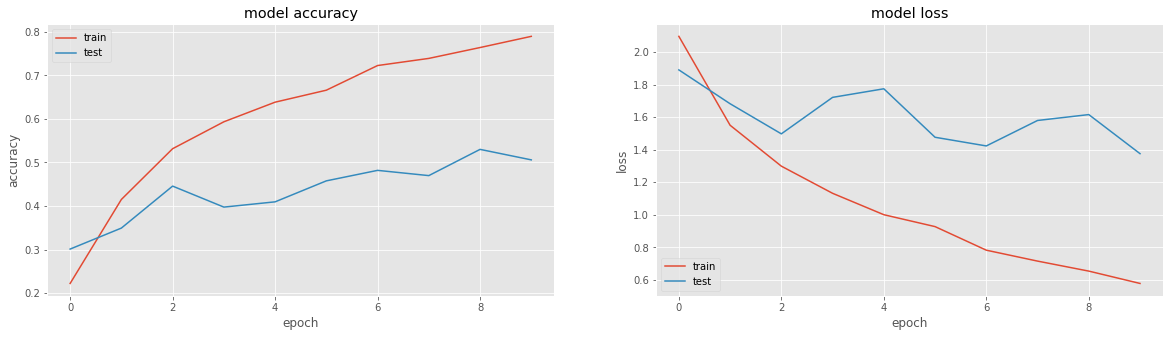

In [15]:
show_history(history)